In [15]:

import sys
import os
sys.path.append(os.getcwd())
import json
import pandas as pd
import numpy as np
from toolz import memoize
import datetime
import math

from tqdm import tqdm
from src.utils.data_classes import MouselabConfig, Action
from src.policy.jas_voc_policy import JAS_voc_policy
import pandas as pd
import seaborn as sns
import numpy as np
from src.utils.env_export import format_payoff
from src.utils.khalili_env import get_env


sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.5)
sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
data = json.load(open("./data/dataclips_5.json"))

In [21]:
language_index = data["fields"].index("language")
response_data_index = data["fields"].index("datastring")
begin_index = data["fields"].index("beginhit")
end_index = data["fields"].index("endhit")

f = '%Y-%m-%d %H:%M:%S.%f'

In [22]:
# Fixed from paper
env, config = get_env(5, term_belief=False)
voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=0.5798921379230035)

In [23]:
def convert_action(project: int, criteria: int, expert: int, config: MouselabConfig) -> Action:
    query = (1 + criteria) + project*config.num_criterias
    action = Action(expert=expert, query=query)
    return action

In [8]:
# Check survey responses, filter participants that respond "No" to the attention question

exclude_answers = ["no"]
known_workers = []
excluded = []
quiz_excluded = 0
participant_age = []
participant_gender = []
participant_durations = []

# Parse raw mturk data into dataframe
for p_index, p_data in tqdm(enumerate(data["values"])):
    # Filter out empty responses
    response_data = p_data[response_data_index]
    if (response_data != None):
        p_res_obj = json.loads(response_data)
        if (not p_res_obj["workerId"].startswith("debug")):
            worker = p_index #p_res_obj["workerId"]#p_index # 
            if worker in known_workers:
                print("Duplicate worker", worker)
            else: 
                known_workers.append(worker)
            p_res = p_res_obj["data"]
            if "quiz_failures" in p_res_obj["questiondata"].keys():
                quiz_failures = p_res_obj["questiondata"]["quiz_failures"]
            else:
                quiz_failures = 0
            completed_test_trials = sum([1 if ('trial_id' in  p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test")) else 0 for i in range(len(p_res))])
            if quiz_failures >= 3:
                quiz_excluded += 1
            elif (quiz_failures < 3) and (completed_test_trials == 10):
                for i in range(len(p_res)):
                    # Get test trials
                    if p_res[i]['trialdata']["trial_type"] == "survey-text":
                        attention_response: str = p_res[i]['trialdata']["response"]["Reward"].lower()
                        if any([attention_response.startswith(answer) for answer in exclude_answers]):
                            print("Exclude", worker, attention_response)
                            excluded.append(worker)
                        else:
                            participant_age.append(p_res[i]['trialdata']["response"]["Age"].lower())
                            participant_gender.append(p_res[i]['trialdata']["response"]["Gender"].lower())
                            if p_data[begin_index] and p_data[end_index]:
                                begin = datetime.datetime.strptime(p_data[begin_index], f)
                                end = datetime.datetime.strptime(p_data[end_index], f)
                                duration = (end - begin).total_seconds()
                                participant_durations.append(duration)

print("Quiz exclusions", quiz_excluded)
print("Effort question exclusions", len(excluded))

385it [00:00, 1345.22it/s]

Exclude 168 not really
Exclude 248 not really
Exclude 283 no
Quiz exclusions 10
Effort question exclusions 3


In [12]:
def calculate_mean_age(ages):
    valid_ages = 0
    total_age = 0
    for age in ages:
        if age.isdigit():
            valid_ages += 1
            total_age += int(age)
        else:
            print("Error", age)
    return total_age / valid_ages
calculate_mean_age(participant_age)

29.08053691275168

In [59]:
env.expert_truths.shape

(6, 31)

In [16]:
def count_gender(genders):
    male = 0
    female = 0
    nb = 0
    for gender in genders:
        if gender.lower().strip() in ["male", "m", "man", "men", "masculin", "masculine"]:
            male += 1
        elif gender.lower().strip() in ["female", "f", "woman", "women", "feminine", "i am female", "femenine"]:
            female += 1
        elif gender.lower().strip() in ["non binary", "non-binary"]:
            nb += 1
        else:
            print("Error", gender)
    return male, female, nb
count_gender(participant_gender)

(147, 148, 3)

In [25]:
median_duration = np.median(participant_durations) / 60
pay = 3.5
bonus = 0.5
pay_per_minute = (pay+bonus) / median_duration
pay_per_hour = pay_per_minute * 60
print(median_duration, pay_per_hour)

22.013963583333336 10.902171210172384


In [43]:
df_index = ["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "Actions", "Selection",
        "Seed", "ClickAgreement"]    
df_all_data = [] # With excluded to calculate bonus payments
df_data = []

bonus_data = {}
known_workers = []
good_responses = 0
demographics = []

participant_actions = []

# Parse raw mturk data into dataframe
for p_index, p_data in tqdm(enumerate(data["values"])):
    # Filter out empty responses
    language = p_data[language_index]
    response_data = p_data[response_data_index]
    if p_data[begin_index] and p_data[end_index]:
        begin = datetime.datetime.strptime(p_data[begin_index], f)
        end = datetime.datetime.strptime(p_data[end_index], f)
        duration = (end - begin).total_seconds()
    else:
        duration = None
    if (response_data != None):
        p_res_obj = json.loads(response_data)
        if (not p_res_obj["workerId"].startswith("debug")):
            condition = p_res_obj["condition"]
            worker = p_index #p_res_obj["workerId"]# 
            if worker in known_workers:
                print("Duplicate worker", worker)
            else: 
                known_workers.append(worker)
            p_res = p_res_obj["data"]
            participant_responses = []
            if "quiz_failures" in p_res_obj["questiondata"].keys():
                quiz_failures = p_res_obj["questiondata"]["quiz_failures"]
            else:
                quiz_failures = 0
            if "final_bonus" in p_res_obj["questiondata"].keys():
                bonus =  p_res_obj["questiondata"]["final_bonus"]
            else:
                bonus = 0
            participant_survey = {"Participant": worker, "Condition": condition, "Language": language, "QuizAttempts": 0, "QuizFailures": quiz_failures, "Bonus": bonus, "Duration": duration}
            completed_test_trials = sum([1 if ('trial_id' in  p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test")) else 0 for i in range(len(p_res))])
            if (quiz_failures < 3) and (completed_test_trials == 10):
                for i in range(len(p_res)):
                    # Get test trials
                    if 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test"):
                        trial_id = p_res[i]['trialdata']['trial_id']
                        seed = int(p_res[i]['trialdata']['seed'])
                        ground_truth = p_res[i]['trialdata']['ground_truth']
                        # project, criteria, expert
                        clicks = p_res[i]['trialdata']["clicks"]
                        num_clicks = len(clicks)
                        selected_project = p_res[i]['trialdata']["selected_project"]
                        term_reward = p_res[i]['trialdata']["reward"]
                        expected_reward = p_res[i]['trialdata']["expected_reward"]
                        # Calculate real env rewards
                        env.reset(seed=seed)
                        actions = [convert_action(*click, config) for click in clicks]
                        participant_actions.extend(actions)
                        cost = 0
                        # Click agreement
                        click_agreement = []
                        for action in actions:
                            optimal_actions = voc_policy.get_best_actions(env, eps=0.001)
                            if action in optimal_actions:
                                click_agreement.append(1)
                            else:
                                click_agreement.append(0)
                            _, reward, _, _ = env.step(action)
                            cost += reward
                        optimal_actions = voc_policy.get_best_actions(env)
                        if env.term_action in optimal_actions:
                            click_agreement.append(1)
                        else:
                            click_agreement.append(0)
                        path = np.array(range(1, config.num_criterias+1))+(selected_project*config.num_criterias)
                        env_expected_reward = cost + env.expected_path_value(path, env.state)
                        env_term_reward = cost + env.path_value(path)
                        assert np.all(np.isclose(ground_truth, env.ground_truth.tolist()))
                        assert np.all(np.isclose(np.array(format_payoff(config.num_projects, config.num_criterias, env.expert_truths.tolist())), p_res[i]['trialdata']['payoff_matrix']))
                        assert np.isclose(term_reward, env_term_reward)
                        assert np.isclose(expected_reward, env_expected_reward)
                        
                        #["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "Actions", "Selection", "Seed", "ClickAgreement"]  
                        if worker not in excluded:
                            df_data.append([worker, condition, trial_id, term_reward, expected_reward, num_clicks, clicks, selected_project, seed, np.mean(click_agreement)])
                        df_all_data.append([worker, condition, trial_id, term_reward, expected_reward, num_clicks, clicks, selected_project, seed, np.mean(click_agreement)])
                    elif 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("train"):
                        pass
                    elif p_res[i]['trialdata']["trial_type"] == "survey-text":
                        pass
                    

df = pd.DataFrame(df_data, columns=df_index)
df_all = pd.DataFrame(df_all_data, columns=df_index)
print("Responses:", len(df["Participant"].unique()))
print("Responseswith excluded :", len(df_all["Participant"].unique()))

385it [40:35,  6.33s/it]

Responses: 298
Responseswith excluded : 301


In [11]:
df = pd.read_csv('data/experiment_results/exp_5.csv')
df.head()

,Unnamed: 0,Participant,Condition,TrialId,Score,ExpectedScore,NumClicks,Actions,Selection,Seed,ClickAgreement
0,0,0,0,test_0,3.430195,3.714933,5,"[[4, 4, 5], [3, 4, 5], [2, 4, 5], [1, 4, 5], [...",4,21,0.333333
1,1,0,0,test_1,3.916634,3.716219,5,"[[0, 4, 1], [1, 4, 1], [2, 4, 1], [3, 4, 1], [...",3,20,0.833333
2,2,0,0,test_2,4.974508,3.539403,5,"[[0, 2, 1], [1, 2, 1], [2, 2, 1], [3, 2, 1], [...",3,19,0.166667
3,3,0,0,test_3,2.594609,3.538759,5,"[[0, 2, 5], [1, 2, 5], [2, 2, 5], [3, 2, 5], [...",3,18,0.166667
4,4,0,0,test_4,5.007722,3.714933,5,"[[0, 4, 5], [1, 4, 5], [2, 4, 5], [3, 4, 5], [...",1,17,0.333333


In [12]:
#project, criteria, expert

tutor_cond_actions = []
control_cond_actions = []
for i in range(len(df)):
    if df.loc[i, "Condition"] == 0:
        control_cond_actions.append(df.loc[i, "Actions"])
    elif df.loc[i, "Condition"] == 1:
        tutor_cond_actions.append(df.loc[i, "Actions"])

print(len(tutor_cond_actions), len(control_cond_actions))   



980 1010


In [13]:
import ast
# Encoding: project, criteria, expert
correct_criteria = [4]
correct_experts = [1, 5]

def count_correct_criteria(actions):
    correct = []
    for action in actions:
        action = ast.literal_eval(action)
        if (len(action) > 0) and (action[0][1] == 4):
            correct.append(1)
        else:
            correct.append(0)
    return sum(correct)

def count_correct_expert(actions):
    correct = []
    for action in actions:
        action = ast.literal_eval(action)
        if (len(action) > 0) and (action[0][2] in [1, 5]):
            correct.append(1)
        else:
            correct.append(0)
    return sum(correct)

def count_correct_action(actions):
    correct = []
    for action in actions:
        action = ast.literal_eval(action)
        if (len(action) > 0) and (action[0][2] in [1, 5]) and (action[0][1] == 4):
            correct.append(1)
        else:
            correct.append(0)
    return sum(correct)

print("Correct criteria: ")
print("Tutor", count_correct_criteria(tutor_cond_actions) / len(tutor_cond_actions))
print("Control", count_correct_criteria(control_cond_actions) / len(control_cond_actions))

print("Correct expert: ")
print("Tutor", count_correct_expert(tutor_cond_actions) / len(tutor_cond_actions))
print("Control", count_correct_expert(control_cond_actions) / len(control_cond_actions))

print("Correct first action: ")
print("Tutor", count_correct_action(tutor_cond_actions) / len(tutor_cond_actions))
print("Control", count_correct_action(control_cond_actions) / len(control_cond_actions))

Correct criteria: 
Tutor 0.6673469387755102
Control 0.4405940594059406
Correct expert: 
Tutor 0.7561224489795918
Control 0.5495049504950495
Correct first action: 
Tutor 0.5785714285714286
Control 0.3336633663366337


In [14]:
print(tutor_cond_actions[:2])

['[[0, 0, 5], [1, 0, 0], [1, 1, 4], [2, 2, 5], [3, 3, 4]]', '[[0, 1, 5], [0, 1, 3], [0, 1, 4], [0, 1, 2]]']


In [ ]:
# Bad experts anywhere
# Bad criteria anywhere
# Ask second expert if 5 is discovered
# Terminate after two 5s
# Switch projects if <5 is discovered

In [81]:
participant_ids = df["Participant"].unique()

all_participant_data = []
for p_index, p_data in tqdm(enumerate(data["values"])):
    response_data = p_data[response_data_index]
    if (response_data != None):
        p_res_obj = json.loads(response_data)
        if (not p_res_obj["workerId"].startswith("debug")):
            condition = p_res_obj["condition"]
            worker = p_index #p_res_obj["workerId"]# 
            if (worker in participant_ids) and (condition in [0, 1]):
                p_res = p_res_obj["data"]
                for i in range(len(p_res)):
                    # Get test trials
                    if 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test"):
                        strategy_data = {"Condition": condition, "Participant": worker, "Trial": p_res[i]['trialdata']['trial_id']}
                        seed = int(p_res[i]['trialdata']['seed'])
                        env.reset(seed=seed)
                        # project, criteria, expert
                        clicks = p_res[i]['trialdata']["clicks"]
                        actions = [convert_action(*click, config) for click in clicks]
                        if len(clicks) > 0:
                            project, criteria, expert = clicks[0]
                            # Correct 1st action expert
                            if expert in correct_experts:
                                strategy_data["FirstActionExpert"] = 1
                            else:
                                strategy_data["FirstActionExpert"] = 0
                            # Correct 1st action criteria
                            if criteria in correct_criteria:
                                strategy_data["FirstActionCriteria"] = 1
                            else:
                                strategy_data["FirstActionCriteria"] = 0
                            # Correct first action
                            if (expert in correct_experts) and (criteria in correct_criteria):
                                strategy_data["FirstAction"] = 1
                            else:
                                strategy_data["FirstAction"] = 0
                            # No bad experts / criteria
                            strategy_data["BadExpert"] = 0
                            strategy_data["BadCriteria"] = 0
                            for click in clicks:
                                project, criteria, expert = click
                                if expert not in correct_experts:
                                    strategy_data["BadExpert"] = 1
                                if criteria not in correct_criteria:
                                    strategy_data["BadCriteria"] = 1
                            
                        if len(clicks) >= 1:
                            project_0, criteria_0, expert_0 = clicks[0]
                            if (expert_0 in correct_experts) and (criteria_0 in correct_criteria):
                                
                                strategy_data["RepeatProject"] = 0
                                strategy_data["SwitchProject"] = 0
                                if len(clicks) >= 2:
                                    project_1, criteria_1, expert_1 = clicks[1]
                                    obs_0 = env.expert_truths[actions[0].expert, actions[0].query]

                                    if (obs_0 == 5) and (project_0 == project_1):# and (expert_1 in correct_experts) and (criteria_1 in correct_criteria):
                                        strategy_data["RepeatProject"] = 1
                                    elif (obs_0 < 5) and (project_0 != project_1):# and (expert_1 in correct_experts) and (criteria_1 in correct_criteria):
                                        strategy_data["SwitchProject"] = 1
                        else:
                            strategy_data["FirstActionExpert"] = 0
                            strategy_data["FirstActionCriteria"] = 0
                            strategy_data["FirstAction"] = 0
                        all_participant_data.append(strategy_data)

385it [00:00, 395.13it/s]


In [82]:
df_strategy = pd.DataFrame(all_participant_data)
df_strategy.drop(columns=["Trial"], inplace=True)
df_strategy.groupby("Condition").mean()

,Participant,FirstActionExpert,FirstActionCriteria,FirstAction,BadExpert,BadCriteria,RepeatProject,SwitchProject
Condition,,,,,,,,
0,217.178218,0.549505,0.440594,0.333663,0.525264,0.653349,0.065282,0.652819
1,217.346939,0.756122,0.667347,0.578571,0.418876,0.470838,0.105820,0.649030


In [ ]:
participant_scores = df_all.groupby("Participant").agg(["mean", "std"])
participant_scores = participant_scores.sort_values(("Score", "mean"), ascending=False)
participant_scores

In [46]:
sorted_participants = participant_scores.index.tolist()
half_participants = math.ceil(len(sorted_participants)/2)
high_bonus = sorted_participants[:half_participants]
low_bonus = sorted_participants[half_participants:]
for id in high_bonus:
    print(f"{id},0.75")
for id in low_bonus:
    print(f"{id},0.25")

293,0.75
75,0.75
225,0.75
210,0.75
266,0.75
7,0.75
205,0.75
44,0.75
250,0.75
31,0.75
312,0.75
344,0.75
324,0.75
307,0.75
165,0.75
333,0.75
82,0.75
28,0.75
240,0.75
358,0.75
85,0.75
280,0.75
180,0.75
172,0.75
217,0.75
276,0.75
195,0.75
367,0.75
354,0.75
15,0.75
302,0.75
359,0.75
308,0.75
321,0.75
89,0.75
216,0.75
288,0.75
65,0.75
212,0.75
118,0.75
51,0.75
178,0.75
181,0.75
126,0.75
234,0.75
24,0.75
166,0.75
84,0.75
222,0.75
204,0.75
34,0.75
56,0.75
223,0.75
96,0.75
29,0.75
338,0.75
262,0.75
48,0.75
151,0.75
268,0.75
383,0.75
171,0.75
373,0.75
169,0.75
260,0.75
335,0.75
343,0.75
197,0.75
190,0.75
346,0.75
186,0.75
349,0.75
193,0.75
112,0.75
130,0.75
177,0.75
340,0.75
52,0.75
9,0.75
364,0.75
313,0.75
120,0.75
184,0.75
156,0.75
331,0.75
162,0.75
0,0.75
272,0.75
353,0.75
140,0.75
11,0.75
6,0.75
122,0.75
378,0.75
257,0.75
237,0.75
78,0.75
264,0.75
125,0.75
294,0.75
183,0.75
131,0.75
301,0.75
279,0.75
214,0.75
352,0.75
128,0.75
285,0.75
98,0.75
292,0.75
368,0.75
213,0.75
366,0.75
2,0.75
164,0

In [47]:
df.to_csv("./data/experiment_results/exp_5.csv")

In [2]:
df = pd.read_csv("./data/experiment_results/exp_5.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'Participant', 'Condition', 'TrialId', 'Score',
       'ExpectedScore', 'NumClicks', 'Actions', 'Selection', 'Seed',
       'ClickAgreement'],
      dtype='object')

In [3]:
df.groupby(["Condition"]).count()["Participant"] / 10

Condition
0    101.0
1     98.0
2     99.0
Name: Participant, dtype: float64

In [5]:
df.groupby("Condition").agg(["mean", "std"]).round(4)[["ExpectedScore", "ClickAgreement", "NumClicks"]]

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_15452\2390542040.py:1: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("Condition").agg(["mean", "std"]).round(4)[["ExpectedScore", "ClickAgreement", "NumClicks"]]


ExpectedScore         ClickAgreement         NumClicks        
                   mean     std           mean     std      mean     std
Condition                                                               
0                3.5176  0.1973         0.2521  0.2777    3.5950  1.8660
1                3.5858  0.1903         0.4271  0.3211    4.0306  1.4204
2                3.5265  0.1922         0.2664  0.2547    3.8646  1.8177

<AxesSubplot: xlabel='Condition', ylabel='ClickAgreement'>

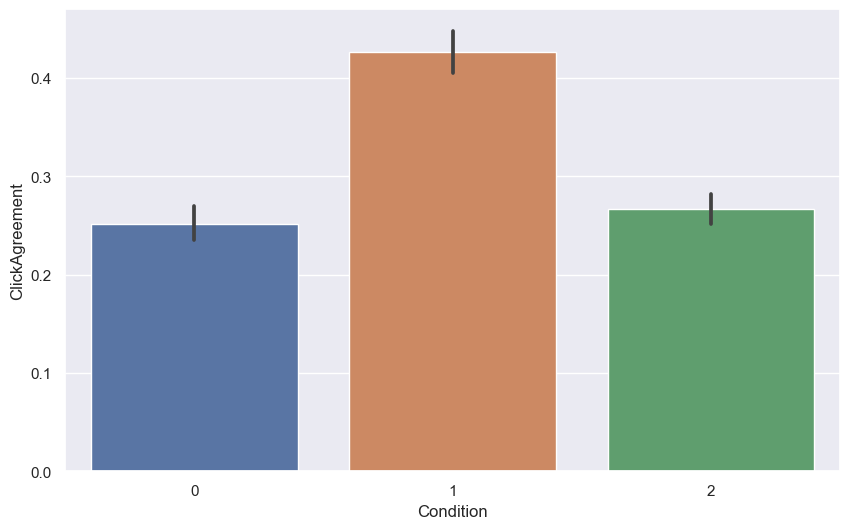

In [4]:
sns.barplot(df, y="ClickAgreement", x="Condition")

(3.3, 3.7)

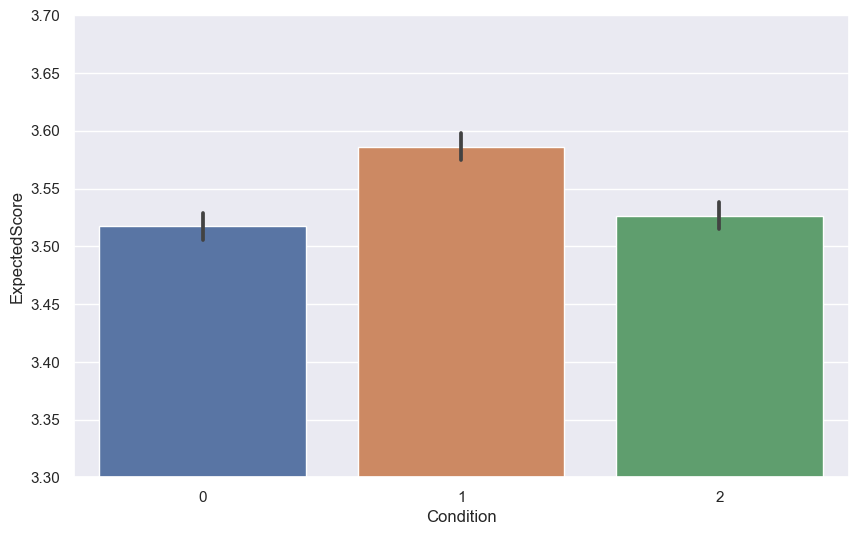

In [5]:
g = sns.barplot(df, y="ExpectedScore", x="Condition")
g.set_ylim(3.3, 3.7)

In [10]:
baseline_df = pd.read_csv("./data/experiment_results/random_baseline.csv")
baseline_df = baseline_df.astype({'seed':'int'}).set_index("seed")
baseline_df

,Unnamed: 0,reward,actions,runtime,true_reward,expected_reward
seed,,,,,,
12,0,3.509576,4.9222,0.001303,3.894847,3.509576
13,1,3.527022,4.9086,0.001295,3.921715,3.527022
14,2,3.498825,4.9246,0.001308,3.610339,3.498825
15,3,3.510792,4.9127,0.001473,3.574298,3.510792
16,4,3.499757,4.9218,0.001420,3.222883,3.499757
17,5,3.572623,4.9146,0.001420,4.224300,3.572623
18,6,3.544299,4.9184,0.001367,3.676118,3.544299
19,7,3.537451,4.9148,0.001414,3.952736,3.537451
20,8,3.517815,4.9179,0.001444,3.435968,3.517815


In [11]:
def get_baseline_result(seed):
    baseline_reward = baseline_df.loc[seed]["reward"]
    return baseline_reward

# df["BaselineReward"] = df["Seed"].apply(get_baseline_result)
# std = df["ExpectedScore"].std()
# df["NormalizedReward"] = (df["ExpectedScore"] - df["BaselineReward"]) / std
# print(df["NormalizedReward"].agg(["mean", "std"]))
# g = sns.barplot(df, y="NormalizedReward", x="Condition")

mean    0.106879
std     1.000000
Name: NormalizedReward, dtype: float64


Text(0.5, 1.0, '(participant_scores - mean(baseline_scores)) / std(participant_scores)')

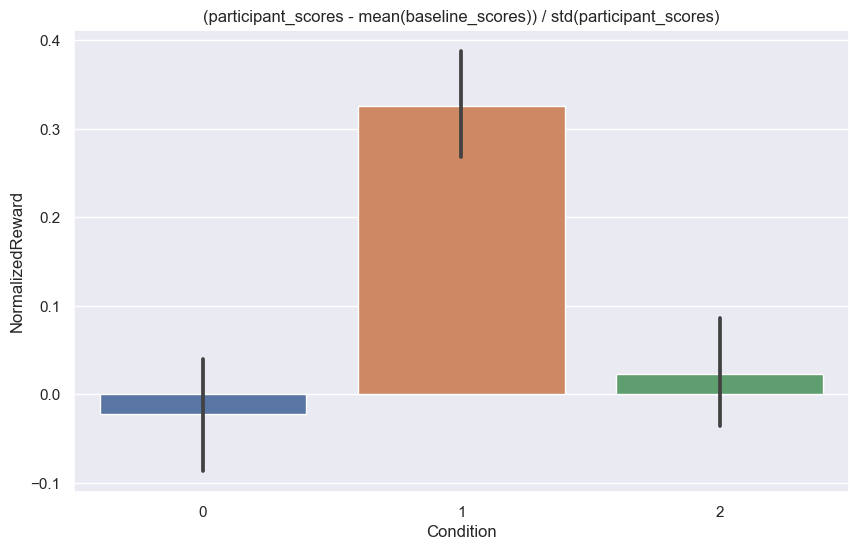

In [12]:
mean = baseline_df["reward"].mean()
std = df["ExpectedScore"].std()
df["NormalizedReward"] = (df["ExpectedScore"] - mean) / std
print(df["NormalizedReward"].agg(["mean", "std"]))
g = sns.barplot(df, y="NormalizedReward", x="Condition")
g.set_title("(participant_scores - mean(baseline_scores)) / std(participant_scores)")

In [9]:
df.groupby("Condition").agg(["mean", "std"]).round(4)[["NormalizedReward", "ClickAgreement"]]

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_8060\4263439442.py:1: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("Condition").agg(["mean", "std"]).round(4)[["NormalizedReward", "ClickAgreement"]]


NormalizedReward         ClickAgreement        
                      mean     std           mean     std
Condition                                                
0                  -0.0227  1.0087         0.2521  0.2777
1                   0.3256  0.9727         0.4271  0.3211
2                   0.0225  0.9827         0.2664  0.2547

In [10]:
def ci(column):
    stats = df.groupby("Condition").agg(["mean", "count", "std"])[column]
    ci95 = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95.append(1.96*s/math.sqrt(c))
    
    stats['ci95'] = ci95
    return stats.round(4)

ci("NormalizedReward")

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_8060\702216816.py:2: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats = df.groupby("Condition").agg(["mean", "count", "std"])[column]


,mean,count,std,ci95
Condition,,,,
0,-0.0227,1010,1.0087,0.0622
1,0.3256,980,0.9727,0.0609
2,0.0225,990,0.9827,0.0612


In [11]:
ci("ClickAgreement")

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_8060\702216816.py:2: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats = df.groupby("Condition").agg(["mean", "count", "std"])[column]


,mean,count,std,ci95
Condition,,,,
0,0.2521,1010,0.2777,0.0171
1,0.4271,980,0.3211,0.0201
2,0.2664,990,0.2547,0.0159


In [19]:
df.columns

Index(['Unnamed: 0', 'Participant', 'Condition', 'TrialId', 'Score',
       'ExpectedScore', 'NumClicks', 'Actions', 'Selection', 'Seed',
       'ClickAgreement', 'NormalizedReward'],
      dtype='object')

In [20]:
def cohend(d1, d2):
    # https://machinelearningmastery.com/effect-size-measures-in-python/
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

def effect_size(column):
    no_tutor = df[df["Condition"]==0][column]
    choice_tutor = df[df["Condition"]==1][column]
    dummy_tutor = df[df["Condition"]==2][column]

    print("Cohen's d between choice tutor and no tutor:", cohend(choice_tutor, no_tutor))
    print("Cohen's d between choice tutor and dummy tutor:", cohend(choice_tutor, dummy_tutor))
    print("Cohen's d between no tutor and dummy tutor:", cohend(no_tutor, dummy_tutor))

effect_size("ExpectedScore")

Cohen's d between choice tutor and no tutor: 0.351383844014203
Cohen's d between choice tutor and dummy tutor: 0.3099789489468115
Cohen's d between no tutor and dummy tutor: -0.04536646854659123


In [14]:
effect_size("ClickAgreement")

Cohen's d between choice tutor and no tutor: 0.5838100844483174
Cohen's d between choice tutor and dummy tutor: 0.5547391888972275
Cohen's d between no tutor and dummy tutor: -0.0539016017253772


In [7]:
# MGPS reward
from simulation import run_simulation
env, config = get_env(5, term_belief=False)
voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=0.5798921379230035)

mgps_res, mgps_actions = run_simulation(env, voc_policy, n=10, start_seed=12)
mgps_res


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


,reward,actions,seed,runtime,true_reward,expected_reward
0,4.330025,5,12,1.062500,4.330025,3.716219
1,4.498135,2,13,0.531250,4.498135,3.823586
2,4.102660,5,14,0.828125,4.102660,3.716219
3,4.280379,3,15,0.781250,4.280379,3.821586
4,3.518098,5,16,0.906250,3.518098,3.499094
5,5.007722,5,17,0.937500,5.007722,3.817586
6,3.775033,3,18,0.781250,3.775033,3.821586
7,4.179104,4,19,0.843750,4.179104,3.819586
8,3.922634,2,20,0.578125,3.922634,3.823586
9,3.673830,5,21,0.875000,3.673830,3.658340


In [16]:
mean = baseline_df["reward"].mean()
std = df["ExpectedScore"].std()
mgps_res["NormalizedReward"] = (mgps_res["expected_reward"] - mean) / std
print(mgps_res["NormalizedReward"].agg(["mean", "std"]))
print(1.96*mgps_res["NormalizedReward"].std()/math.sqrt(mgps_res["NormalizedReward"].count()))

mean    1.174134
std     0.549778
Name: NormalizedReward, dtype: float64
0.3407559011074728


In [17]:
mgps_res

,reward,actions,seed,runtime,true_reward,expected_reward,NormalizedReward
0,4.330025,5,12,1.062500,4.330025,3.716219,0.992555
1,4.498135,2,13,0.531250,4.498135,3.823586,1.541417
2,4.102660,5,14,0.828125,4.102660,3.716219,0.992555
3,4.280379,3,15,0.781250,4.280379,3.821586,1.531193
4,3.518098,5,16,0.906250,3.518098,3.499094,-0.117385
5,5.007722,5,17,0.937500,5.007722,3.817586,1.510745
6,3.775033,3,18,0.781250,3.775033,3.821586,1.531193
7,4.179104,4,19,0.843750,4.179104,3.819586,1.520969
8,3.922634,2,20,0.578125,3.922634,3.823586,1.541417
9,3.673830,5,21,0.875000,3.673830,3.658340,0.696680


In [37]:
mgps_tutor_mean = df[df["Condition"]==1].groupby("Participant").mean()["NormalizedReward"]
print(np.mean(mgps_tutor_mean > 0.9))

0.22448979591836735


C:\Users\lheindrich\AppData\Local\Temp\ipykernel_15452\1996396165.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mgps_tutor_mean = df[df["Condition"]==1].groupby("Participant").mean()["NormalizedReward"]


<AxesSubplot: xlabel='NormalizedReward', ylabel='Percent'>

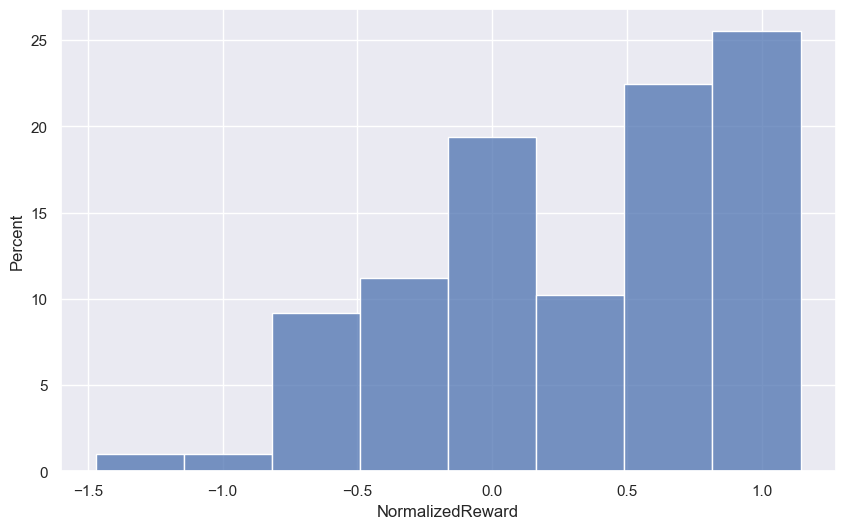

In [27]:
sns.histplot(mgps_tutor_mean, stat="percent")